In [ ]:
!mkdir results

In [3]:
import cv2
import numpy as np
from scipy.ndimage import sobel
from math import log, exp
from tqdm import tqdm
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

## Implementation

In [4]:
def compute_local_contrast(block):
    return block.max() - block.min()

def compute_cpbd(image, img_name, file_name, kernel_size):
  if len(image.shape) == 3:
    Y = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
  else:
    Y = image.copy()

  Y = Y.astype(np.float32)

  # applying the sobel operator vertically to find the horizontal edges
  grad_y = cv2.Sobel(Y, cv2.CV_64F, 0, 1, ksize=  kernel_size)
  abs_grad_y = np.abs(grad_y)
  height, width = Y.shape

  edge_blocks = []
  block_size = 64

  for y in range(0, height - block_size + 1, block_size):
    for x in range(0, width - block_size + 1, block_size):
      block = abs_grad_y[y:y+block_size, x:x+block_size]
      local_max = cv2.dilate(block, np.ones((3, 1)))

      edges = (block == local_max) & (block > 0.05 * block.max())
      edge_indices = np.argwhere(edges)

      for idx in edge_indices:

        i, j = idx
        py, px = y + i, x + j

        profile = abs_grad_y[max(0, py-5):min(height, py+6), px]
        peaks = np.where(profile > 0.5 * profile.max())[0]

        if len(peaks) >= 2:
          edge_width = peaks[-1] - peaks[0]
          local_block = Y[max(0, py-3):min(height, py+4), max(0, px-3):min(width, px+4)]

          C = compute_local_contrast(local_block)
          if C <= 50:
            gamma = 5 * 0.9984
            omega = 2 if edge_width <= 2 else 3
          else:
            gamma = 3 * 0.9984
            omega = 2

          beta = 3.6
          P_blur = 1 - exp(- (edge_width / omega) ** beta)
          P_jnb = 0.63

          # edge blocks array indicate that if the block is blur: 1 or not: 0
          edge_blocks.append(P_blur <= P_jnb)

  if len(edge_blocks) == 0:
      return 0.0
  CPBD = np.sum(edge_blocks) / len(edge_blocks)
  
  with open( f"./results/{file_name}.txt", "a" ) as f:
    f.write( f"The cpbd score of the {img_name}: {CPBD}\n")

  return CPBD

## Individual Usage

In [ ]:
img = cv2.imread('data/blur_dataset1/defocused_blurred/0_IPHONE-SE_F.JPG')
score = compute_cpbd( img )
print(f"CPBD Blur Score: {score:.4f}")

# Evaluation

## Data Indexing

In [5]:
data =[
  { 'name': 'awentar_unscaled_sharp_frames' ,'path': './data/blur_dataset1/sharp'  },
  { 'name': 'awentar_unscaled_defocusedBlur_frames' ,'path': './data/blur_dataset1/defocused_blurred'  },
  { 'name': 'awentar_unscaled_motionBlur_frames' ,'path': './data/blur_dataset1/motion_blurred'  },
  { 'name': 'awentar_scaled_sharp_frames' ,'path': './data/blur_dataset1/blur_dataset_scaled/sharp'  },
  { 'name': 'awentar_scaled_defocusedBlur_frames' ,'path': './data/blur_dataset1/blur_dataset_scaled/defocused_blurred'  },
  { 'name': 'awentar_scaled_motionBlur_frames' ,'path': './data/blur_dataset1/blur_dataset_scaled/motion_blurred'  },
  { 'name': 'mini_awentar_unscaled_sharp_frames' ,'path': './data/mini_blur_dataset1/sharp'  },
  { 'name': 'mini_awentar_unscaled_defocusedBlur_frames' ,'path': './data/mini_blur_dataset1/defocused_blurred'  },
  { 'name': 'mini_awentar_unscaled_motionBlur_frames' ,'path': './data/mini_blur_dataset1/motion_blurred'  },
  { 'name': 'mini_awentar_scaled_sharp_frames' ,'path': './data/mini_blur_dataset1/blur_dataset_scaled/sharp'  },
  { 'name': 'mini_awentar_scaled_defocusedBlur_frames' ,'path': './data/mini_blur_dataset1/blur_dataset_scaled/defocused_blurred'  },
  { 'name': 'mini_awentar_scaled_motionBlur_frames' ,'path': './data/mini_blur_dataset1/blur_dataset_scaled/motion_blurred'  },
]

## Utility methods

In [6]:
def load_dir(dir_path: str, file_name: str):
  img_arr = []
  img_name = []
  for img_path in tqdm(os.listdir(dir_path)):
      name = img_path
      img = cv2.imread(f"{dir_path}/{img_path}")
      img_arr.append(img)
      img_name.append(name)

  with open(f"./results/{file_name}.txt", "a") as f:
      f.write(f"----------------------Writing results for the directory {dir_path}----------------------------------\n\n")

  return img_arr, img_name

def find_avg_fnc(img_arr, img_name, oper_fnc, file_name, kernel_size =3):
  files_name = [file_name] * len(img_arr)
  kernel_sizes = [ kernel_size ] * len( img_arr )
  
  max_workers = max(1, int(os.cpu_count() * 0.7))
  with ProcessPoolExecutor(max_workers=max_workers) as executor:
    results = list(tqdm(executor.map(oper_fnc, img_arr, img_name, files_name, kernel_sizes), total=len(img_arr)))
    
  avg_value = sum(results) / len(results)
  
  with open(f"./results/{file_name}.txt", "a") as f:
    f.write(f"\n\nThe Average of the cpbd is: {avg_value}\n")
  
  return avg_value


## Evaluation on kwentar dataset(blur_dataset1)

In [10]:
for i in range( len(data) ):

  images, img_names= load_dir( data[i]['path'] )
  avg= find_avg_fnc( img_arr=images, img_name=img_names, oper_fnc=compute_cpbd, file_name=data[i]['name'], dir_path= data[i]['path'] )
  print(f"The average cpbd value for the data {data[i]['name']} is {avg}")

100%|██████████| 350/350 [14:53<00:00,  2.55s/it]


The average cpbd value for the data awentar_scaled_sharp_frames is 0.08839489591549472


100%|██████████| 350/350 [18:15<00:00,  3.13s/it]


The average cpbd value for the data awentar_scaled_defocusedBlur_frames is 0.05555327704434801


100%|██████████| 350/350 [19:58<00:00,  3.42s/it]

The average cpbd value for the data awentar_scaled_motionBlur_frames is 0.06718793564057181


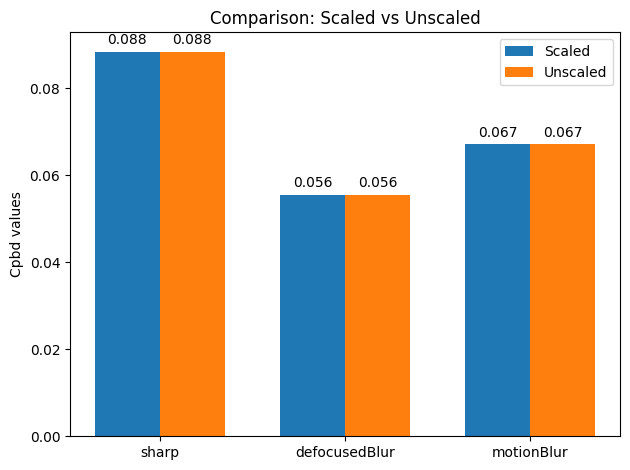

In [7]:
result1 = {
  'awenter': {
    'scaled': {
      'sharp': 0.08839,
      'defocusedBlur': 0.05555,
      'motionBlur': 0.06718,
    },
    'unscaled': {
      'sharp': 0.08839,
      'defocusedBlur': 0.05555,
      'motionBlur': 0.06718,
    }
  }
}

categories = list(result1['awenter']['scaled'].keys())
scaled_values = list(result1['awenter']['scaled'].values())
unscaled_values = list(result1['awenter']['unscaled'].values())
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scaled_values, width, label='Scaled')
rects2 = ax.bar(x + width/2, unscaled_values, width, label='Unscaled')

ax.set_ylabel('Cpbd values')
ax.set_title('Comparison: Scaled vs Unscaled')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Impact of kernel on the the cpbd value for the `mini_awentar_unscaled_sharp_frames`

In [7]:
for kernel_size in range( 3,13,2 ):
  for i in range( len(data) ):

    if ( data[i]['name'] == 'mini_awentar_unscaled_sharp_frames' ):
      
      images, img_names= load_dir( data[i]['path'], f"{data[i]['name']}_kernel{kernel_size}" )
      avg= find_avg_fnc( img_arr=images, img_name= img_names, file_name= f"{data[i]['name']}_kernel{kernel_size}", kernel_size= kernel_size, oper_fnc= compute_cpbd  )
      print(f"The average cpbd value for the data {data[i]['name']} is {avg}")

  0%|          | 0/50 [00:06<?, ?it/s]


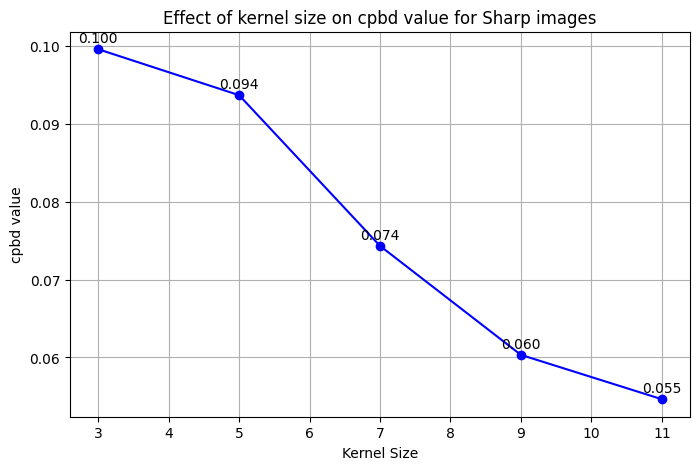

In [8]:
result2 = {
  '3': 0.09962,
  '5': 0.09371,
  '7':0.074338,
  '9': 0.06033,
  '11': 0.05463
}

x = list(map(int, result2.keys()))
y = list(result2.values())

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Labels and Title
plt.xlabel('Kernel Size')
plt.ylabel('cpbd value')
plt.title('Effect of kernel size on cpbd value for Sharp images')
plt.grid(True)

for i, value in enumerate(y):
  plt.annotate(f'{value:.3f}', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.show()


### Impact of kernel on the the cpbd value for the `mini_awentar_unscaled_defocusedBlur_frames`

In [9]:
for kernel_size in range( 3,13,2 ):
  for i in range( len(data) ):

    if ( data[i]['name'] == 'mini_awentar_unscaled_defocusedBlur_frames' ):
      
      images, img_names= load_dir( data[i]['path'], f"{data[i]['name']}_kernel{kernel_size}" )
      avg= find_avg_fnc( img_arr=images, img_name= img_names, file_name= f"{data[i]['name']}_kernel{kernel_size}", kernel_size= kernel_size, oper_fnc= compute_cpbd  )
      print(f"The average cpbd value for the data {data[i]['name']} is {avg}")

100%|██████████| 50/50 [03:15<00:00,  3.90s/it]


The average cpbd value for the data mini_awentar_unscaled_defocusedBlur_frames is 0.06327205217287728


100%|██████████| 50/50 [02:27<00:00,  2.94s/it]


The average cpbd value for the data mini_awentar_unscaled_defocusedBlur_frames is 0.07133233477107703


100%|██████████| 50/50 [02:06<00:00,  2.54s/it]


The average cpbd value for the data mini_awentar_unscaled_defocusedBlur_frames is 0.061782740881662246


100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


The average cpbd value for the data mini_awentar_unscaled_defocusedBlur_frames is 0.049617928445479915


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]

The average cpbd value for the data mini_awentar_unscaled_defocusedBlur_frames is 0.04262851981200684


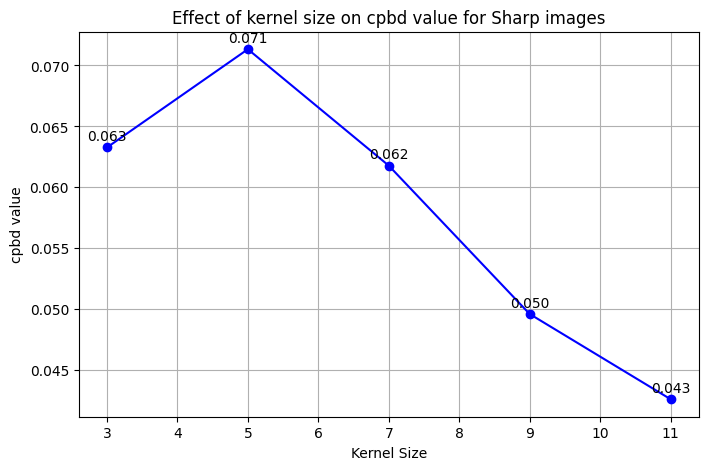

In [10]:
result3= {
  '3': 0.06327,
  '5': 0.07133,
  '7': 0.06178,
  '9': 0.04961,
  '11': 0.04262
}


x = list(map(int, result3.keys()))
y = list(result3.values())

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Labels and Title
plt.xlabel('Kernel Size')
plt.ylabel('cpbd value')
plt.title('Effect of kernel size on cpbd value for Sharp images')
plt.grid(True)

for i, value in enumerate(y):
  plt.annotate(f'{value:.3f}', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.show()

# Theory

Sobel operator detects edges by highlighting areas where intensity changes sharply. Vertical Sobel detects horizontal edges ( jaise a flat line). Horizontal Sobel detects vertical edges.

Human eyes are more sensitive to blur along horizontal edges.Many natural scenes and man-made environments (roads, tables, landscapes) have dominant horizontal structures.  By focusing on vertical Sobel (horizontal edges), the algorithm is simple, efficient and can focus on blur. Studies have shown that measuring blur along horizontal edges gives reliable results without needing to compute both directions.

https://ieeexplore.ieee.org/document/4561452

https://www.sciencedirect.com/science/article/pii/S0042698918302050

### Approach
We estimate image blur using the Cumulative Probability of Blur Detection (CPBD) metric. 
- A higher CPBD score indicates a sharper image, while a lower score indicates a blurrier image.

#### Key Steps in the Method:

1. Convert to Grayscale (Luminance): Extracting the Y (luminance) channel because it has been observed blur mainly affects intensity, not color. next apply Vertical Sobel Operator and detect horizontal edges by applying a vertical Sobel filter.

2. The image is divided into 64x64 pixel blocks for localized analysis. Next, We find strong Edge Points. and detect local maxima in the vertical Sobel gradient.

3. Edges must be above 5% of the maximum block gradient to be considered.

4. For each strong edge, a vertical profile around the point is extracted.

5. newt we find Edge Width and measures how spread out the edge is.
6. We can conclude that wider edges indicate blur.

7. Finally, We compute Local Contrast, blurry regions typically show lower contrast.

8. Based on edge width, the probability that a human would detect blur is calculated.

9. If probability of blur <= 0.63, the edge is considered sharp.

10. Final CPBD Score === Ratio of sharp edges to total detected edges.